<a href="https://colab.research.google.com/github/oikn2018/CS6910_assignment_2/blob/main/a2_part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install wandb
!wandb login --relogin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [2]:
!pip install wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import random
import wget
import os
import datetime
from zipfile import ZipFile
from PIL import Image
from torchvision.datasets import ImageFolder
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Subset
from sklearn.model_selection import train_test_split
from torchvision import models
import wandb
import copy
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
# dir(models)

In [4]:
url='https://storage.googleapis.com/wandb_datasets/nature_12K.zip'
filename = os.path.basename(url)

if not os.path.exists(filename) and not os.path.exists("inaturalist_12K"):
  filename = wget.download(url)
  with ZipFile(filename, 'r') as z:
    print('Extracting files...')
    z.extractall()
    print('Done!')
  os.remove(filename)

In [5]:
classes = sorted([name for name in os.listdir("inaturalist_12K/train") if name != '.DS_Store'])
print(classes)

['Amphibia', 'Animalia', 'Arachnida', 'Aves', 'Fungi', 'Insecta', 'Mammalia', 'Mollusca', 'Plantae', 'Reptilia']


In [6]:
image_size = (256,256)
num_classes = len(classes)

In [7]:
#default config
config = {
    "data_augment": False,
    "learning_rate": 0.0001,
    "batch_size":32,
    "wandb_project": 'Testing',
    "wandb_entity": 'dl_research'
    }

In [8]:
batch_size = config['batch_size']
# trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform.ToTensor())

if config["data_augment"]:
    transform_train = transforms.Compose([
        transforms.RandomRotation(degrees=50),
        transforms.ColorJitter(brightness=(0.2,0.8)),
        transforms.RandomAffine(degrees=0, translate=(0.1,0.2), shear=0, scale=(0.7, 1.3)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
        transforms.RandomResizedCrop(224)
    ])
else:
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
        transforms.RandomResizedCrop(224)
    ])


transform_val = transforms.Compose([
    # transforms.RandomResizedCrop(256),
    # transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5,0.5,0.5)),
    transforms.RandomResizedCrop(224)
])

train_dataset = ImageFolder(
    'inaturalist_12K/train',
    transform=transform_train
)

val_dataset = ImageFolder(
    'inaturalist_12K/train',
    transform=transform_val
)


# generate indices: instead of the actual data we pass in integers instead
train_indices, test_indices, _, _ = train_test_split(
    range(len(train_dataset)),
    train_dataset.targets,
    stratify=train_dataset.targets,
    test_size=0.2,
    random_state=0
)

# generate subset based on indices
train_split = Subset(train_dataset, train_indices)
test_split = Subset(train_dataset, test_indices)

# create batches
train_loader = torch.utils.data.DataLoader(train_split, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_split, batch_size=batch_size, shuffle=False)


In [9]:
def imshow(img, title):
  npimg = img.numpy()/2 + 0.5
  plt.figure(figsize = (batch_size, 10))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

In [10]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [classes[x.item()] for x in labels])
  # imshow(img, title = [[x.item()] for x in labels])

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


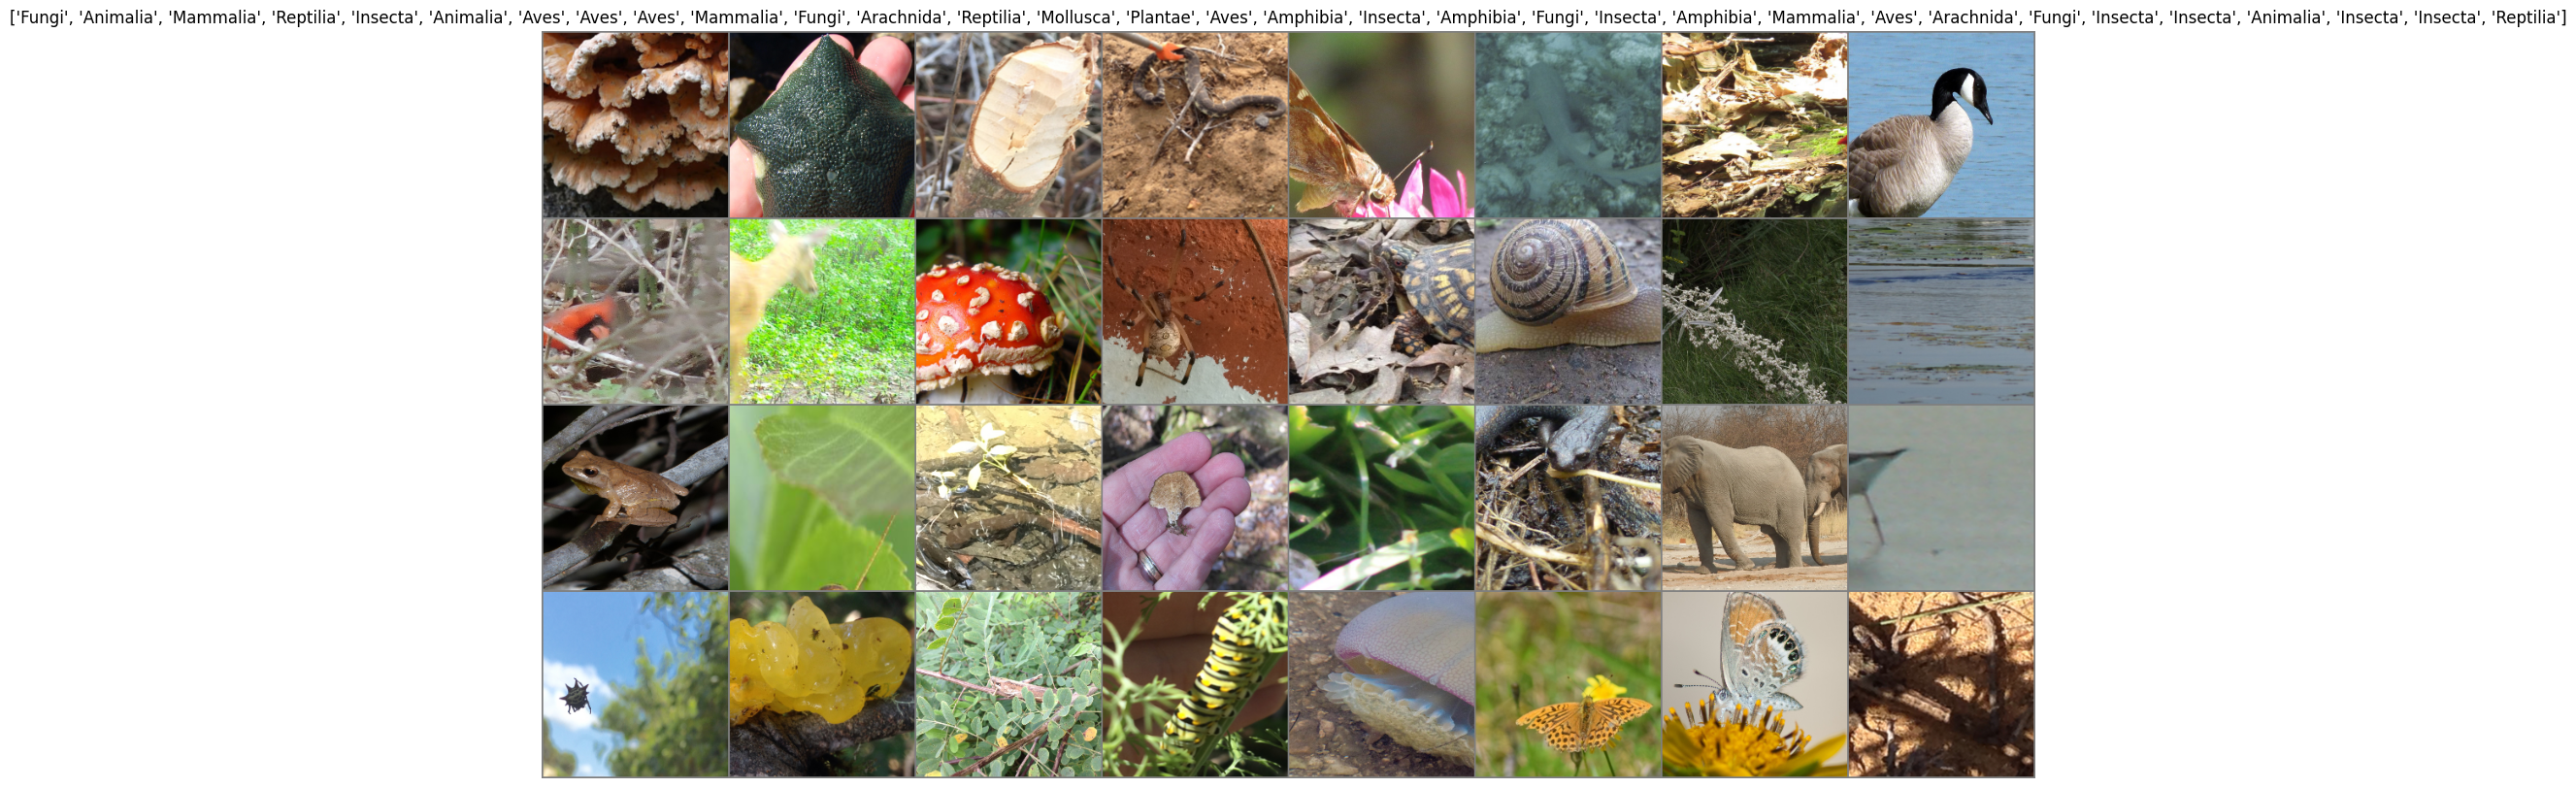

In [11]:
for i in range(1):
  show_batch_images(train_loader)

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [13]:
def evaluation(dataloader, model):
  total, correct = 0, 0
  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    max_values, pred_class = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (pred_class == labels).sum().item()
  return 100*correct/total

In [14]:
resnet = models.resnet50(pretrained=True)
print(resnet)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [15]:
print(sum(p.numel() for p in resnet.parameters()))

25557032


In [16]:
for param in resnet.parameters():
  param.requires_grad = False

In [17]:
final_in_features = resnet.fc.in_features
resnet.fc= nn.Linear(final_in_features, num_classes)

In [18]:
resnet = resnet.to(device)

In [19]:
next(resnet.parameters()).is_cuda

True

In [20]:
for param in resnet.parameters():
  if param.requires_grad:
    print(param.shape)

torch.Size([10, 2048])
torch.Size([10])


In [21]:
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=config['learning_rate'])

In [22]:

sweep_config_partb = {
    "name" : "Assignment2_PB_Q2",
    "method" : "bayes",
    'metric': {
        'name': 'validation_accuracy',
        'goal': 'maximize'
    },
    "parameters" : {
        "batch_size": {
            "values": [config['batch_size']]
        },

        'learning_rate':{
            "values": [config['learning_rate']]
        },
        "data_augment": {
              "values": [config['data_augment']]
        }
      
    }
}

In [23]:
sweep_id_partb = wandb.sweep(sweep_config_partb,project=config['wandb_project'], entity=config['wandb_entity'])

Create sweep with ID: jt2ymslg
Sweep URL: https://wandb.ai/dl_research/Testing/sweeps/jt2ymslg


In [24]:
def train():
  torch.cuda.empty_cache()
  with wandb.init() as run:

    # config = wandb.config

    batch_size = config['batch_size']
    loss_arr = []
    loss_ep_arr = []
    max_epochs = 10

    min_loss = 1000
    n_iters = np.ceil(8000/batch_size)

    for epoch in range(max_epochs):
      torch.cuda.empty_cache()
      for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        opt.zero_grad()
        outputs = resnet(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()

        # if min_loss > loss.item():
        #   min_loss = loss.item()
        #   best_model = copy.deepcopy(resnet.state_dict())
        #   print('Min Loss: %0.2f'%min_loss)

        # if i % 100 == 0:
        #   print('Iteration: %d/%d, Loss: %0.2f'%(i, n_iters, loss.item()))

        del inputs, labels, outputs
        torch.cuda.empty_cache()

        loss_arr.append(loss.item())
      loss_ep_arr.append(loss.item())
      train_acc = evaluation(train_loader, resnet)
      val_acc = evaluation(val_loader, resnet)
      print('Epoch: %d/%d, Loss: %0.2f, Validation accuracy: %0.2f, Train accuracy: %0.2f'%((epoch+1), max_epochs, loss.item(), train_acc, val_acc))
      metrics = {
            "accuracy":train_acc,
            "loss":loss.item(),
            "validation_accuracy": val_acc,
            "epochs":(epoch+1)
            }
      wandb.log(metrics)
 

In [25]:
wandb.agent(sweep_id_partb, function=train, count=1)

wandb: Agent Starting Run: erbbd5ue with config:
wandb: 	batch_size: 32
wandb: 	data_augment: False
wandb: 	learning_rate: 0.0001
wandb: Currently logged in as: cs22s013 (dl_research). Use `wandb login --relogin` to force relogin


Epoch: 1/10, Loss: 1.34, Validation accuracy: 65.56, Train accuracy: 65.65
Epoch: 2/10, Loss: 1.31, Validation accuracy: 69.87, Train accuracy: 69.50
Epoch: 3/10, Loss: 0.96, Validation accuracy: 70.82, Train accuracy: 70.80
Epoch: 4/10, Loss: 0.86, Validation accuracy: 72.58, Train accuracy: 71.50
Epoch: 5/10, Loss: 0.84, Validation accuracy: 72.42, Train accuracy: 72.05
Epoch: 6/10, Loss: 1.00, Validation accuracy: 72.47, Train accuracy: 73.45
Epoch: 7/10, Loss: 0.85, Validation accuracy: 73.36, Train accuracy: 74.30
Epoch: 8/10, Loss: 1.01, Validation accuracy: 73.67, Train accuracy: 74.35
Epoch: 9/10, Loss: 0.86, Validation accuracy: 74.68, Train accuracy: 73.60
Epoch: 10/10, Loss: 0.75, Validation accuracy: 74.98, Train accuracy: 73.70


accuracy,▁▄▅▆▆▆▇▇██
epochs,▁▂▃▃▄▅▆▆▇█
loss,██▃▂▂▄▂▄▂▁
validation_accuracy,▁▄▅▆▆▇██▇▇
accuracy,74.98437
epochs,10
loss,0.75112
validation_accuracy,73.7
